In [1]:
import pandas as pd
import os
from openpyxl import load_workbook
from tqdm import tqdm
from functools import reduce

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

In [3]:
merged_df = pd.read_parquet("../../data/merged_era5data/merged_df_bhutan_time.parquet")

### Model training

In [6]:
# Step 1: Aggregate to daily resolution
merged_df["date"] = merged_df["datetime"].dt.date

daily_df = (
    merged_df
    .groupby(["date", "latitude", "longitude"])
    [["temperature", "wind_u", "wind_v", "precipitation", "surface_runoff"]]
    .mean()
    .reset_index()
)

daily_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258335 entries, 0 to 1258334
Data columns (total 8 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   date            1258335 non-null  object 
 1   latitude        1258335 non-null  float64
 2   longitude       1258335 non-null  float64
 3   temperature     1258335 non-null  float64
 4   wind_u          1258335 non-null  float64
 5   wind_v          1258335 non-null  float64
 6   precipitation   1258335 non-null  float64
 7   surface_runoff  1258335 non-null  float64
dtypes: float64(7), object(1)
memory usage: 76.8+ MB


In [7]:
daily_df.head(5)

,date,latitude,longitude,temperature,wind_u,wind_v,precipitation,surface_runoff
0,2000-01-01,26.5,88.50,17.790700,0.526337,-0.523936,0.0,0.0
1,2000-01-01,26.5,88.75,18.639659,0.742157,-0.268402,0.0,0.0
2,2000-01-01,26.5,89.00,18.626638,0.421193,-0.674652,0.0,0.0
3,2000-01-01,26.5,89.25,18.195648,0.154917,-0.920746,0.0,0.0
4,2000-01-01,26.5,89.50,17.944346,-0.241892,-1.018077,0.0,0.0


### Start training the model

In [ ]:
# Copy and prepare
df = daily_df.copy()
df['date'] = pd.to_datetime(df['date'])
df['log_runoff'] = np.log1p(df['surface_runoff'])  # Safe for zero
features = ['temperature', 'wind_u', 'wind_v', 'precipitation']
target = 'log_runoff'

# Models to compare
model_dict = {
    'linear': LinearRegression(),
    'random_forest': RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42),
    'xgboost': xgb.XGBRegressor(n_estimators=50, max_depth=3, random_state=42)
}

In [80]:
# Group and evaluate
grouped = df.groupby(['latitude', 'longitude'])
results = []

total = len(grouped)
count = 0

for (lat, lon), group in grouped:
    
    count += 1
    print(f"🔄 Processing {count}/{total}: (lat={lat}, lon={lon})")
    
    group = group.sort_values('date')

    if len(group) < 100 or group['surface_runoff'].sum() == 0:
        continue

    # Time-based split
    split_index = int(len(group) * 0.8)
    train = group.iloc[:split_index]

    X_train = train[features].values
    y_train = train[target].values

    row_result = {'latitude': lat, 'longitude': lon}

    for name, model in model_dict.items():
        try:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_train)
            r2 = r2_score(y_train, y_pred)
            rmse = mean_squared_error(y_train, y_pred)
            row_result[f'{name}_r2_train'] = r2
            row_result[f'{name}_rmse_train'] = rmse
        except Exception as e:
            row_result[f'{name}_r2_train'] = None
            row_result[f'{name}_rmse_train'] = None
            print(f"Error for model {name} at ({lat},{lon}):", e)

    results.append(row_result)

# Compile results
results_df = pd.DataFrame(results)

🔄 Processing 1/135: (lat=26.5, lon=88.5)
🔄 Processing 2/135: (lat=26.5, lon=88.75)
🔄 Processing 3/135: (lat=26.5, lon=89.0)
🔄 Processing 4/135: (lat=26.5, lon=89.25)
🔄 Processing 5/135: (lat=26.5, lon=89.5)
🔄 Processing 6/135: (lat=26.5, lon=89.75)
🔄 Processing 7/135: (lat=26.5, lon=90.0)
🔄 Processing 8/135: (lat=26.5, lon=90.25)
🔄 Processing 9/135: (lat=26.5, lon=90.5)
🔄 Processing 10/135: (lat=26.5, lon=90.75)
🔄 Processing 11/135: (lat=26.5, lon=91.0)
🔄 Processing 12/135: (lat=26.5, lon=91.25)
🔄 Processing 13/135: (lat=26.5, lon=91.5)
🔄 Processing 14/135: (lat=26.5, lon=91.75)
🔄 Processing 15/135: (lat=26.5, lon=92.0)
🔄 Processing 16/135: (lat=26.75, lon=88.5)
🔄 Processing 17/135: (lat=26.75, lon=88.75)
🔄 Processing 18/135: (lat=26.75, lon=89.0)
🔄 Processing 19/135: (lat=26.75, lon=89.25)
🔄 Processing 20/135: (lat=26.75, lon=89.5)
🔄 Processing 21/135: (lat=26.75, lon=89.75)
🔄 Processing 22/135: (lat=26.75, lon=90.0)
🔄 Processing 23/135: (lat=26.75, lon=90.25)
🔄 Processing 24/135: (la

In [84]:
# Extract only R² columns
r2_cols = ['linear_r2_train', 'random_forest_r2_train', 'xgboost_r2_train']

# For each row, find the model with the highest training R²
results_df['best_model'] = results_df[r2_cols].idxmax(axis=1).str.replace('_r2_train', '')
results_df

# Count frequency of each best model
model_counts = results_df['best_model'].value_counts()

# Print as table
print("Best Model Count by Spatial Unit:")
print(model_counts)

,latitude,longitude,linear_r2_train,linear_rmse_train,random_forest_r2_train,random_forest_rmse_train,xgboost_r2_train,xgboost_rmse_train,best_model
0,26.5,88.50,0.798566,2.613651e-08,0.967077,4.271827e-09,9.397921e-01,7.812132e-09,random_forest
1,26.5,88.75,0.783155,3.492053e-08,0.969360,4.934296e-09,9.354085e-01,1.040176e-08,random_forest
2,26.5,89.00,0.785099,3.112237e-08,0.969201,4.460392e-09,9.522502e-01,6.915220e-09,random_forest
3,26.5,89.25,0.779362,2.690023e-08,0.971483,3.476756e-09,9.391158e-01,7.423012e-09,random_forest
4,26.5,89.50,0.802199,2.736615e-08,0.971859,3.893328e-09,9.344576e-01,9.067917e-09,random_forest
...,...,...,...,...,...,...,...,...,...
130,28.5,91.00,0.117054,8.345755e-09,0.563390,4.126917e-09,4.166782e-01,5.513658e-09,random_forest
131,28.5,91.25,0.135752,4.323015e-09,0.368218,3.160212e-09,2.017760e-01,3.992761e-09,random_forest
132,28.5,91.50,0.480368,2.572831e-10,0.648394,1.740892e-10,1.615927e-01,4.151169e-10,random_forest
133,28.5,91.75,0.461698,1.975215e-10,0.755928,8.955849e-11,-2.220446e-16,3.669345e-10,random_forest


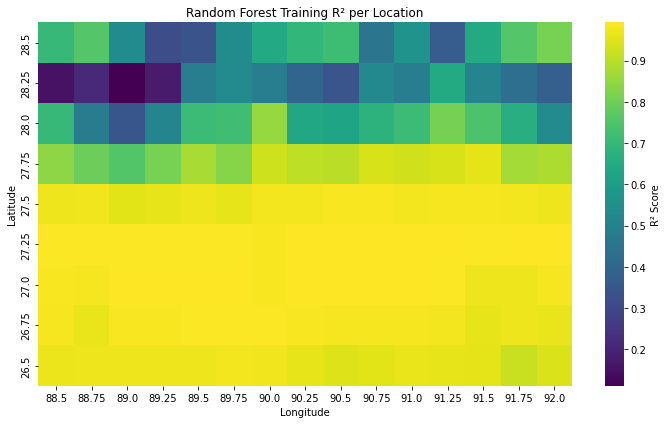

In [88]:
# Pivot for heatmap
pivot_r2 = results_df.pivot(index='latitude', columns='longitude', values='random_forest_r2_train')

# R² heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot_r2.sort_index(ascending=False),  # flip latitude for top-down view
    cmap='viridis',
    annot=False,
    cbar_kws={'label': 'R² Score'}
)

plt.title("Random Forest Training R² per Location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


### Do both training and testing

In [96]:
# Copy and prepare
df = daily_df.copy()
df['date'] = pd.to_datetime(df['date'])
df['log_runoff'] = np.log1p(df['surface_runoff'])  # for safety
features = ['temperature', 'wind_u', 'wind_v', 'precipitation']
target = 'log_runoff'

grouped = df.groupby(['latitude', 'longitude'])
results = []
predictions = []

total = len(grouped)
count = 0

for (lat, lon), group in grouped:
    
    count += 1
    print(f"🔄 Processing {count}/{total}: (lat={lat}, lon={lon})")
    
    group = group.sort_values('date')

    # Skip unusable data
    if len(group) < 100 or group['surface_runoff'].sum() == 0:
        continue

    # Time-based split
    split_index = int(len(group) * 0.8)
    train = group.iloc[:split_index]
    test = group.iloc[split_index:]

    X_train = train[features]
    y_train = train[target]
    X_test = test[features]
    y_test = test[target]

    model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
    model.fit(X_train, y_train)

    # Train performance
    y_pred_train = model.predict(X_train)
    r2_train = r2_score(y_train, y_pred_train)
    rmse_train = mean_squared_error(y_train, y_pred_train)

    # Test performance
    y_pred_test = model.predict(X_test)
    r2_test = r2_score(y_test, y_pred_test)
    rmse_test = mean_squared_error(y_test, y_pred_test)

    # Store metrics
    results.append({
        'latitude': lat,
        'longitude': lon,
        'r2_train': r2_train,
        'rmse_train': rmse_train,
        'r2_test': r2_test,
        'rmse_test': rmse_test
    })

    # Store predictions (optional)
    temp_df = test[['date', 'surface_runoff']].copy()
    temp_df['predicted_log'] = y_pred_test
    temp_df['predicted_runoff'] = np.expm1(y_pred_test)  # back to original scale
    temp_df['latitude'] = lat
    temp_df['longitude'] = lon
    predictions.append(temp_df)

# Compile results
results_df = pd.DataFrame(results)
pred_df = pd.concat(predictions).reset_index(drop=True)


🔄 Processing 1/135: (lat=26.5, lon=88.5)
🔄 Processing 2/135: (lat=26.5, lon=88.75)
🔄 Processing 3/135: (lat=26.5, lon=89.0)
🔄 Processing 4/135: (lat=26.5, lon=89.25)
🔄 Processing 5/135: (lat=26.5, lon=89.5)
🔄 Processing 6/135: (lat=26.5, lon=89.75)
🔄 Processing 7/135: (lat=26.5, lon=90.0)
🔄 Processing 8/135: (lat=26.5, lon=90.25)
🔄 Processing 9/135: (lat=26.5, lon=90.5)
🔄 Processing 10/135: (lat=26.5, lon=90.75)
🔄 Processing 11/135: (lat=26.5, lon=91.0)
🔄 Processing 12/135: (lat=26.5, lon=91.25)
🔄 Processing 13/135: (lat=26.5, lon=91.5)
🔄 Processing 14/135: (lat=26.5, lon=91.75)
🔄 Processing 15/135: (lat=26.5, lon=92.0)
🔄 Processing 16/135: (lat=26.75, lon=88.5)
🔄 Processing 17/135: (lat=26.75, lon=88.75)
🔄 Processing 18/135: (lat=26.75, lon=89.0)
🔄 Processing 19/135: (lat=26.75, lon=89.25)
🔄 Processing 20/135: (lat=26.75, lon=89.5)
🔄 Processing 21/135: (lat=26.75, lon=89.75)
🔄 Processing 22/135: (lat=26.75, lon=90.0)
🔄 Processing 23/135: (lat=26.75, lon=90.25)
🔄 Processing 24/135: (la

In [97]:
results_df

,latitude,longitude,r2_train,rmse_train,r2_test,rmse_test
0,26.5,88.50,0.967310,4.241575e-09,0.900486,7.938357e-09
1,26.5,88.75,0.970537,4.744765e-09,0.918790,1.039540e-08
2,26.5,89.00,0.970750,4.236015e-09,0.930536,9.234210e-09
3,26.5,89.25,0.971636,3.458140e-09,0.940081,8.720457e-09
4,26.5,89.50,0.971778,3.904503e-09,0.940954,9.505020e-09
...,...,...,...,...,...,...
130,28.5,91.00,0.565407,4.107848e-09,0.322787,4.556609e-09
131,28.5,91.25,0.370549,3.148552e-09,0.311633,2.051572e-09
132,28.5,91.50,0.647879,1.743443e-10,0.641266,2.721718e-10
133,28.5,91.75,0.757140,8.911389e-11,0.696267,1.355524e-10


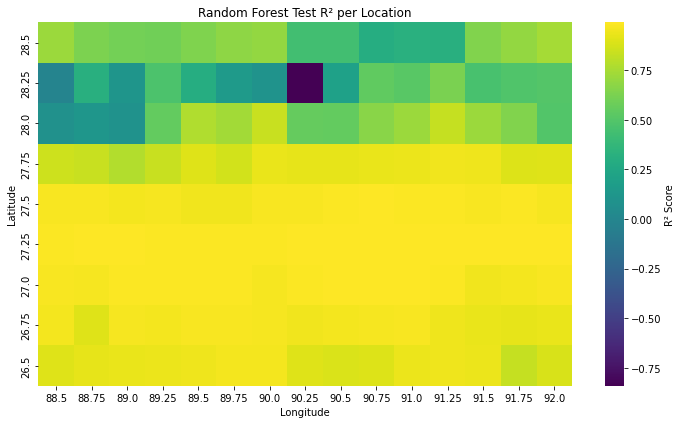

In [98]:
# Pivot for heatmap
pivot_r2 = results_df.pivot(index='latitude', columns='longitude', values='r2_test')

# R² heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot_r2.sort_index(ascending=False),  # flip latitude for top-down view
    cmap='viridis',
    annot=False,
    cbar_kws={'label': 'R² Score'}
)

plt.title("Random Forest Test R² per Location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


### This is after adding more features

In [92]:
# Copy and prep
df = daily_df.copy()
df['date'] = pd.to_datetime(df['date'])
base_features = ['temperature', 'wind_u', 'wind_v', 'precipitation']

# --- Step 1: Feature Engineering ---
for col in base_features:
    df[f'{col}_lag1'] = df.groupby(['latitude', 'longitude'])[col].shift(1)
    df[f'{col}_lag3'] = df.groupby(['latitude', 'longitude'])[col].shift(3)
    df[f'{col}_roll3'] = df.groupby(['latitude', 'longitude'])[col].transform(lambda x: x.rolling(3).mean())
    df[f'{col}_roll7'] = df.groupby(['latitude', 'longitude'])[col].transform(lambda x: x.rolling(7).mean())

df['dayofyear'] = df['date'].dt.dayofyear
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.weekday
df['week'] = df['date'].dt.isocalendar().week.astype(int)

df['wind_speed'] = np.sqrt(df['wind_u']**2 + df['wind_v']**2)
df['temp_precip'] = df['temperature'] * df['precipitation']

df['log_runoff'] = np.log1p(df['surface_runoff'])  # log(1+x)

# Drop NA rows from lag/rolling
df = df.groupby(['latitude', 'longitude'], group_keys=False).apply(lambda g: g.dropna()).reset_index(drop=True)

# Define features
exclude_cols = ['date', 'surface_runoff', 'log_runoff', 'latitude', 'longitude']
features = [col for col in df.columns if col not in exclude_cols]
target = 'log_runoff'

# --- Step 2: Model Setup ---
model_dict = {
    'linear': LinearRegression(),
    'random_forest': RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42),
    'xgboost': xgb.XGBRegressor(n_estimators=50, max_depth=3, random_state=42)
}

# --- Step 3: Train/Eval by Spatial Unit ---
results = []
grouped = df.groupby(['latitude', 'longitude'])

for i, ((lat, lon), group) in enumerate(grouped, 1):
    group = group.sort_values('date')

    if len(group) < 100 or group['surface_runoff'].sum() == 0:
        continue

    print(f"[{i}] Training models for location (lat={lat}, lon={lon}), n={len(group)}")

    # Train/test split
    split_idx = int(len(group) * 0.8)
    train = group.iloc[:split_idx]
    X_train = train[features].values
    y_train = train[target].values

    row_result = {'latitude': lat, 'longitude': lon}

    for name, model in model_dict.items():
        try:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_train)
            r2 = r2_score(y_train, y_pred)
            rmse = mean_squared_error(y_train, y_pred)
            row_result[f'{name}_r2_train'] = r2
            row_result[f'{name}_rmse_train'] = rmse
        except Exception as e:
            row_result[f'{name}_r2_train'] = None
            row_result[f'{name}_rmse_train'] = None
            print(f"❌ Error for model {name} at ({lat},{lon}):", e)

    results.append(row_result)

# Compile results
results_df = pd.DataFrame(results)


/var/folders/w1/6bg1f9b95nv9ffmqmk5plvb80000gn/T/ipykernel_89382/2828943326.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['latitude', 'longitude'], group_keys=False).apply(lambda g: g.dropna()).reset_index(drop=True)


[1] Training models for location (lat=26.5, lon=88.5), n=9315
[2] Training models for location (lat=26.5, lon=88.75), n=9315
[3] Training models for location (lat=26.5, lon=89.0), n=9315
[4] Training models for location (lat=26.5, lon=89.25), n=9315
[5] Training models for location (lat=26.5, lon=89.5), n=9315
[6] Training models for location (lat=26.5, lon=89.75), n=9315
[7] Training models for location (lat=26.5, lon=90.0), n=9315
[8] Training models for location (lat=26.5, lon=90.25), n=9315
[9] Training models for location (lat=26.5, lon=90.5), n=9315
[10] Training models for location (lat=26.5, lon=90.75), n=9315
[11] Training models for location (lat=26.5, lon=91.0), n=9315
[12] Training models for location (lat=26.5, lon=91.25), n=9315
[13] Training models for location (lat=26.5, lon=91.5), n=9315
[14] Training models for location (lat=26.5, lon=91.75), n=9315
[15] Training models for location (lat=26.5, lon=92.0), n=9315
[16] Training models for location (lat=26.75, lon=88.5), 

[129] Training models for location (lat=28.5, lon=90.5), n=9315
[130] Training models for location (lat=28.5, lon=90.75), n=9315
[131] Training models for location (lat=28.5, lon=91.0), n=9315
[132] Training models for location (lat=28.5, lon=91.25), n=9315
[133] Training models for location (lat=28.5, lon=91.5), n=9315
[134] Training models for location (lat=28.5, lon=91.75), n=9315
[135] Training models for location (lat=28.5, lon=92.0), n=9315


In [93]:
# Extract only R² columns
r2_cols = ['linear_r2_train', 'random_forest_r2_train', 'xgboost_r2_train']

# For each row, find the model with the highest training R²
results_df['best_model'] = results_df[r2_cols].idxmax(axis=1).str.replace('_r2_train', '')
results_df

# Count frequency of each best model
model_counts = results_df['best_model'].value_counts()

# Print as table
print("Best Model Count by Spatial Unit:")
print(model_counts)

Best Model Count by Spatial Unit:
best_model
random_forest    135
Name: count, dtype: int64


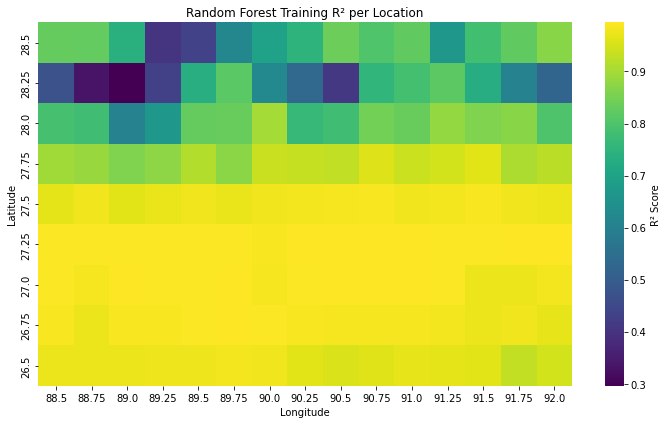

In [94]:
# Pivot for heatmap
pivot_r2 = results_df.pivot(index='latitude', columns='longitude', values='random_forest_r2_train')

# R² heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot_r2.sort_index(ascending=False),  # flip latitude for top-down view
    cmap='viridis',
    annot=False,
    cbar_kws={'label': 'R² Score'}
)

plt.title("Random Forest Training R² per Location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


In [99]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# --- Step 1: Feature Engineering ---
df = daily_df.copy()
df['date'] = pd.to_datetime(df['date'])

# Base features
base_features = ['temperature', 'wind_u', 'wind_v', 'precipitation']

# Lag and rolling features
for col in base_features:
    df[f'{col}_lag1'] = df.groupby(['latitude', 'longitude'])[col].shift(1)
    df[f'{col}_lag3'] = df.groupby(['latitude', 'longitude'])[col].shift(3)
    df[f'{col}_roll3'] = df.groupby(['latitude', 'longitude'])[col].transform(lambda x: x.rolling(3).mean())
    df[f'{col}_roll7'] = df.groupby(['latitude', 'longitude'])[col].transform(lambda x: x.rolling(7).mean())

# Date features
df['dayofyear'] = df['date'].dt.dayofyear
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.weekday
df['week'] = df['date'].dt.isocalendar().week.astype(int)

# Interaction features
df['wind_speed'] = np.sqrt(df['wind_u']**2 + df['wind_v']**2)
df['temp_precip'] = df['temperature'] * df['precipitation']

# Log-transform the target
df['log_runoff'] = np.log1p(df['surface_runoff'])

# Drop NaNs introduced by rolling/lags
df = df.groupby(['latitude', 'longitude'], group_keys=False).apply(lambda g: g.dropna()).reset_index(drop=True)

# Final feature set
exclude_cols = ['date', 'surface_runoff', 'log_runoff', 'latitude', 'longitude']
features = [col for col in df.columns if col not in exclude_cols]

# --- Step 2: Train and Test per Spatial Unit ---

grouped = df.groupby(['latitude', 'longitude'])
results = []

for i, ((lat, lon), group) in enumerate(grouped, 1):
    print(f"[{i}] Training and testing for location (lat={lat}, lon={lon}), n={len(group)}")
    
    group = group.sort_values('date')

    if len(group) < 100 or group['surface_runoff'].sum() == 0:
        continue

    split_idx = int(len(group) * 0.8)
    train = group.iloc[:split_idx]
    test = group.iloc[split_idx:]

    X_train = train[features]
    y_train = train['log_runoff']
    X_test = test[features]
    y_test = test['log_runoff']

    model = RandomForestRegressor(n_estimators=50, max_depth=6, random_state=42)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    r2_train = r2_score(y_train, y_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

    r2_test = r2_score(y_test, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    results.append({
        'latitude': lat,
        'longitude': lon,
        'r2_train': r2_train,
        'rmse_train': rmse_train,
        'r2_test': r2_test,
        'rmse_test': rmse_test
    })

# --- Step 3: Results Summary ---
results_df = pd.DataFrame(results)


/var/folders/w1/6bg1f9b95nv9ffmqmk5plvb80000gn/T/ipykernel_89382/1525262968.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['latitude', 'longitude'], group_keys=False).apply(lambda g: g.dropna()).reset_index(drop=True)


[1] Training and testing for location (lat=26.5, lon=88.5), n=9315
[2] Training and testing for location (lat=26.5, lon=88.75), n=9315
[3] Training and testing for location (lat=26.5, lon=89.0), n=9315
[4] Training and testing for location (lat=26.5, lon=89.25), n=9315
[5] Training and testing for location (lat=26.5, lon=89.5), n=9315
[6] Training and testing for location (lat=26.5, lon=89.75), n=9315
[7] Training and testing for location (lat=26.5, lon=90.0), n=9315
[8] Training and testing for location (lat=26.5, lon=90.25), n=9315
[9] Training and testing for location (lat=26.5, lon=90.5), n=9315
[10] Training and testing for location (lat=26.5, lon=90.75), n=9315
[11] Training and testing for location (lat=26.5, lon=91.0), n=9315
[12] Training and testing for location (lat=26.5, lon=91.25), n=9315
[13] Training and testing for location (lat=26.5, lon=91.5), n=9315
[14] Training and testing for location (lat=26.5, lon=91.75), n=9315
[15] Training and testing for location (lat=26.5, 

[120] Training and testing for location (lat=28.25, lon=92.0), n=9315
[121] Training and testing for location (lat=28.5, lon=88.5), n=9315
[122] Training and testing for location (lat=28.5, lon=88.75), n=9315
[123] Training and testing for location (lat=28.5, lon=89.0), n=9315
[124] Training and testing for location (lat=28.5, lon=89.25), n=9315
[125] Training and testing for location (lat=28.5, lon=89.5), n=9315
[126] Training and testing for location (lat=28.5, lon=89.75), n=9315
[127] Training and testing for location (lat=28.5, lon=90.0), n=9315
[128] Training and testing for location (lat=28.5, lon=90.25), n=9315
[129] Training and testing for location (lat=28.5, lon=90.5), n=9315
[130] Training and testing for location (lat=28.5, lon=90.75), n=9315
[131] Training and testing for location (lat=28.5, lon=91.0), n=9315
[132] Training and testing for location (lat=28.5, lon=91.25), n=9315
[133] Training and testing for location (lat=28.5, lon=91.5), n=9315
[134] Training and testing 

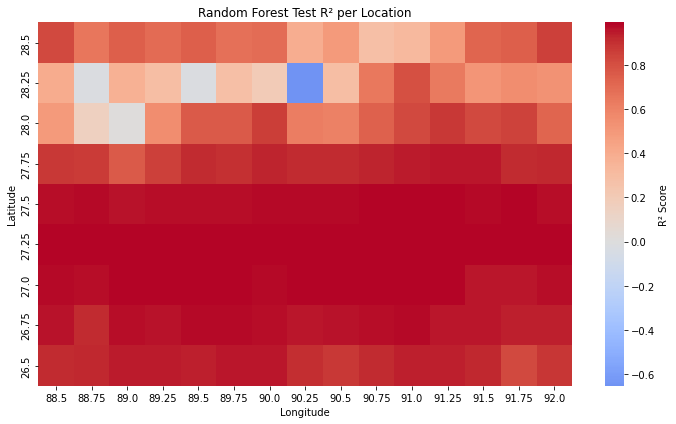

In [102]:
# Pivot for heatmap
pivot_r2 = results_df.pivot(index='latitude', columns='longitude', values='r2_test')

# R² heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot_r2.sort_index(ascending=False),  # flip latitude for top-down view
    cmap='coolwarm',
    center=0,
    annot=False,
    cbar_kws={'label': 'R² Score'}
)

plt.title("Random Forest Test R² per Location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


### Ran the model on a single spatial unit

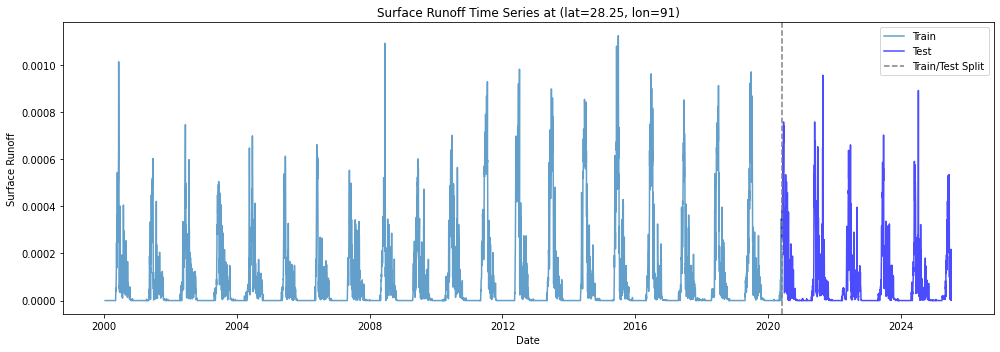

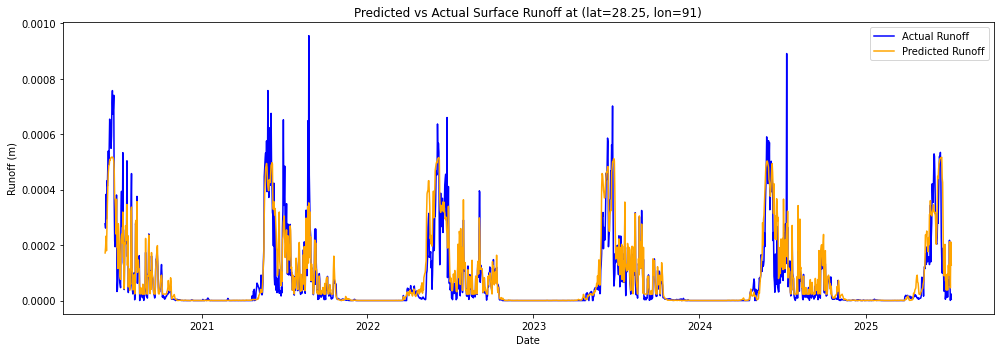

/var/folders/w1/6bg1f9b95nv9ffmqmk5plvb80000gn/T/ipykernel_89382/2958101632.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')


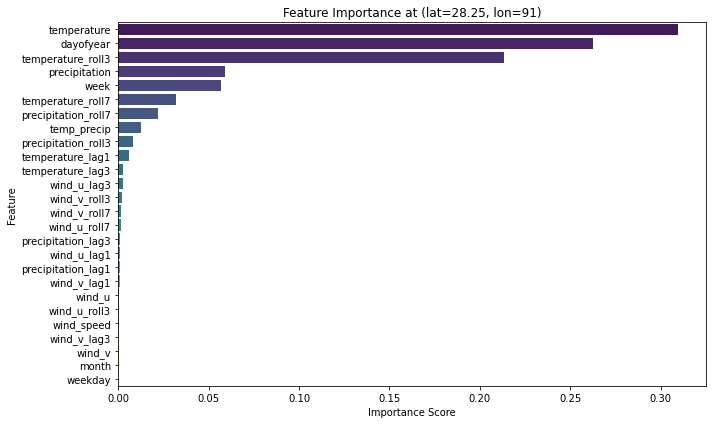

In [119]:
# Choose one spatial unit
lat_example = 28.25
lon_example = 91

# Filter and sort
example_group = df[(df['latitude'] == lat_example) & (df['longitude'] == lon_example)].copy()
example_group = example_group.sort_values('date')

# Create all features again (must match what was used in modeling)
example_group['wind_speed'] = np.sqrt(example_group['wind_u']**2 + example_group['wind_v']**2)
example_group['temp_precip'] = example_group['temperature'] * example_group['precipitation']
example_group['log_runoff'] = np.log1p(example_group['surface_runoff'])
for col in ['temperature', 'wind_u', 'wind_v', 'precipitation']:
    example_group[f'{col}_lag1'] = example_group[col].shift(1)
    example_group[f'{col}_lag3'] = example_group[col].shift(3)
    example_group[f'{col}_roll3'] = example_group[col].rolling(3).mean()
    example_group[f'{col}_roll7'] = example_group[col].rolling(7).mean()
example_group['dayofyear'] = example_group['date'].dt.dayofyear
example_group['month'] = example_group['date'].dt.month
example_group['weekday'] = example_group['date'].dt.weekday
example_group['week'] = example_group['date'].dt.isocalendar().week.astype(int)
example_group.dropna(inplace=True)

# Define features and target
target = 'log_runoff'
features = [col for col in example_group.columns if col not in ['date', 'surface_runoff', 'log_runoff', 'latitude', 'longitude']]

# Split train/test based on time
split_index = int(len(example_group) * 0.8)
train = example_group.iloc[:split_index]
test = example_group.iloc[split_index:]

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

# Plot time series: surface runoff over time with train/test marked
plt.figure(figsize=(14, 5))
plt.plot(train['date'], train['surface_runoff'], label='Train', alpha=0.7)
plt.plot(test['date'], test['surface_runoff'], label='Test', alpha=0.7, color='blue')
plt.axvline(test['date'].iloc[0], color='gray', linestyle='--', label='Train/Test Split')
plt.title(f"Surface Runoff Time Series at (lat={lat_example}, lon={lon_example})")
plt.xlabel("Date")
plt.ylabel("Surface Runoff")
plt.legend()
plt.tight_layout()
plt.show()

# Train the model again for this location
model = RandomForestRegressor(n_estimators=200, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

# Plot actual vs predicted time series
plt.figure(figsize=(14, 5))
plt.plot(test['date'], y_true, label='Actual Runoff', color='blue')
plt.plot(test['date'], y_pred, label='Predicted Runoff', color='orange')
plt.title(f"Predicted vs Actual Surface Runoff at (lat={lat_example}, lon={lon_example})")
plt.xlabel("Date")
plt.ylabel("Runoff (m)")
plt.legend()
plt.tight_layout()
plt.show()


# Get feature importances
importances = model.feature_importances_

# Match with feature names
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns if hasattr(X_train, 'columns') else features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)




/var/folders/w1/6bg1f9b95nv9ffmqmk5plvb80000gn/T/ipykernel_89382/2002554309.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')


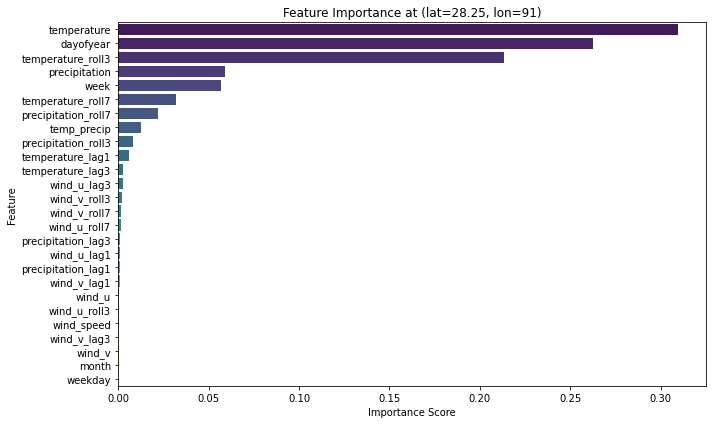

In [120]:
# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')
plt.title(f"Feature Importance at (lat={lat_example}, lon={lon_example})")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

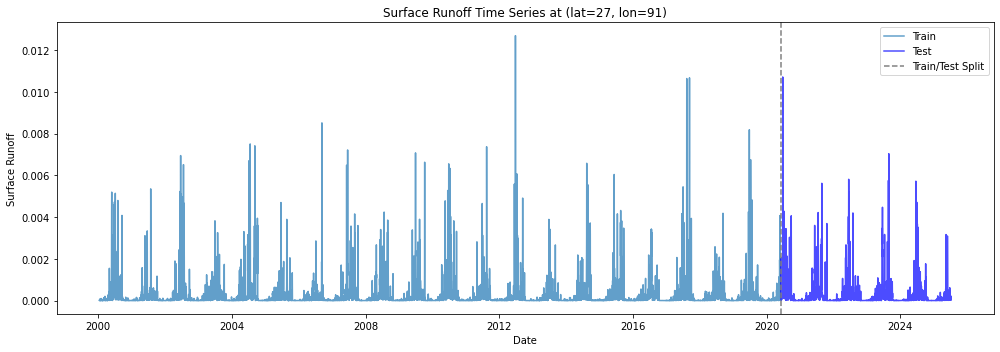

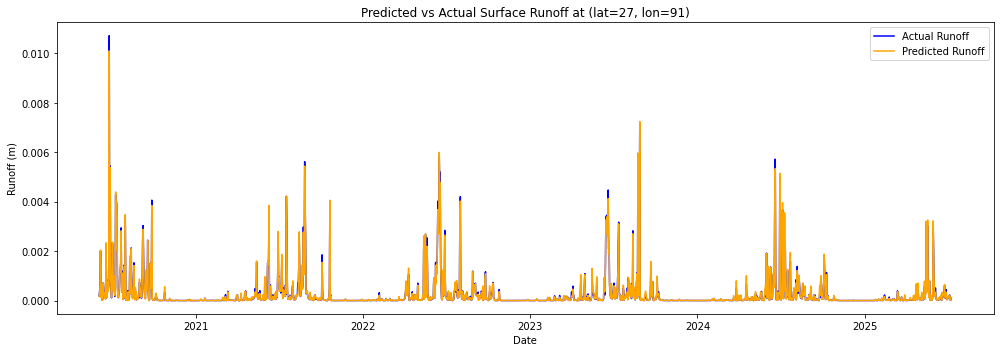

/var/folders/w1/6bg1f9b95nv9ffmqmk5plvb80000gn/T/ipykernel_89382/3936196267.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')


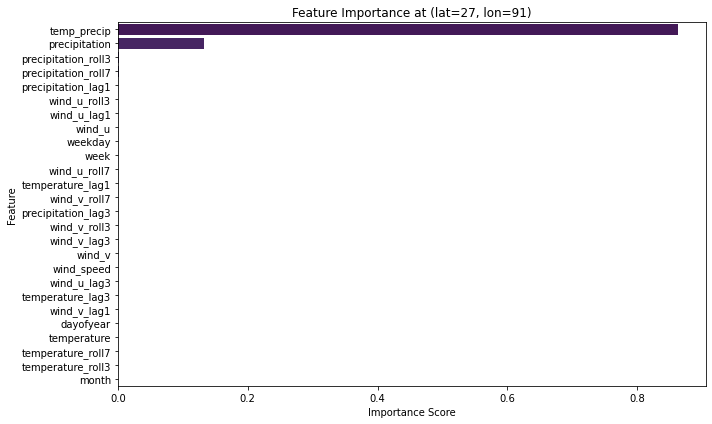

In [116]:
# Choose one spatial unit
lat_example = 27
lon_example = 91

# Filter and sort
example_group = df[(df['latitude'] == lat_example) & (df['longitude'] == lon_example)].copy()
example_group = example_group.sort_values('date')

# Create all features again (must match what was used in modeling)
example_group['wind_speed'] = np.sqrt(example_group['wind_u']**2 + example_group['wind_v']**2)
example_group['temp_precip'] = example_group['temperature'] * example_group['precipitation']
example_group['log_runoff'] = np.log1p(example_group['surface_runoff'])
for col in ['temperature', 'wind_u', 'wind_v', 'precipitation']:
    example_group[f'{col}_lag1'] = example_group[col].shift(1)
    example_group[f'{col}_lag3'] = example_group[col].shift(3)
    example_group[f'{col}_roll3'] = example_group[col].rolling(3).mean()
    example_group[f'{col}_roll7'] = example_group[col].rolling(7).mean()
example_group['dayofyear'] = example_group['date'].dt.dayofyear
example_group['month'] = example_group['date'].dt.month
example_group['weekday'] = example_group['date'].dt.weekday
example_group['week'] = example_group['date'].dt.isocalendar().week.astype(int)
example_group.dropna(inplace=True)

# Define features and target
target = 'log_runoff'
features = [col for col in example_group.columns if col not in ['date', 'surface_runoff', 'log_runoff', 'latitude', 'longitude']]

# Split train/test based on time
split_index = int(len(example_group) * 0.8)
train = example_group.iloc[:split_index]
test = example_group.iloc[split_index:]

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

# Plot time series: surface runoff over time with train/test marked
plt.figure(figsize=(14, 5))
plt.plot(train['date'], train['surface_runoff'], label='Train', alpha=0.7)
plt.plot(test['date'], test['surface_runoff'], label='Test', alpha=0.7, color='blue')
plt.axvline(test['date'].iloc[0], color='gray', linestyle='--', label='Train/Test Split')
plt.title(f"Surface Runoff Time Series at (lat={lat_example}, lon={lon_example})")
plt.xlabel("Date")
plt.ylabel("Surface Runoff")
plt.legend()
plt.tight_layout()
plt.show()

# Train the model again for this location
model = RandomForestRegressor(n_estimators=200, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

# Plot actual vs predicted time series
plt.figure(figsize=(14, 5))
plt.plot(test['date'], y_true, label='Actual Runoff', color='blue')
plt.plot(test['date'], y_pred, label='Predicted Runoff', color='orange')
plt.title(f"Predicted vs Actual Surface Runoff at (lat={lat_example}, lon={lon_example})")
plt.xlabel("Date")
plt.ylabel("Runoff (m)")
plt.legend()
plt.tight_layout()
plt.show()


# Get feature importances
importances = model.feature_importances_

# Match with feature names
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns if hasattr(X_train, 'columns') else features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')
plt.title(f"Feature Importance at (lat={lat_example}, lon={lon_example})")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
